/home/topalidis/.pyenv/versions/3.11.12/lib/python3.11/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
/home/topalidis/.pyenv/versions/3.11.12/lib/python3.11/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/topalidis/.pyenv/versions/3.11.12/lib/python3.11/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


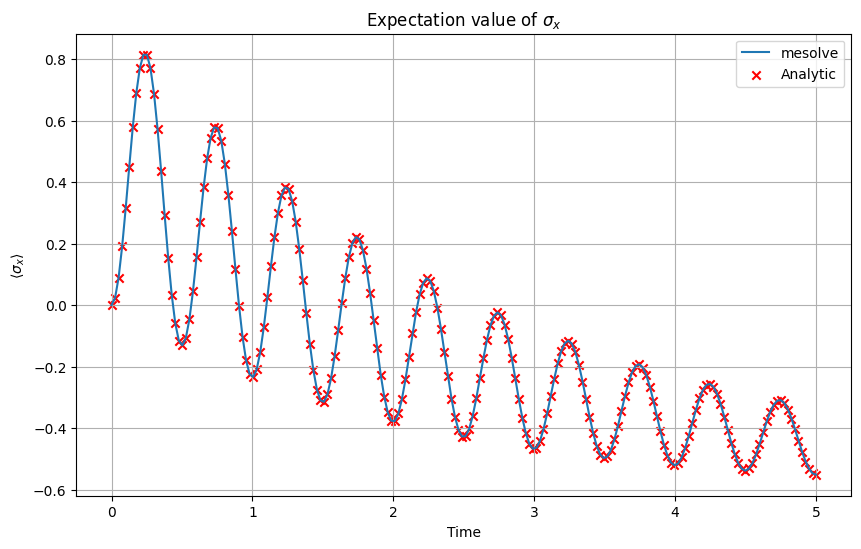

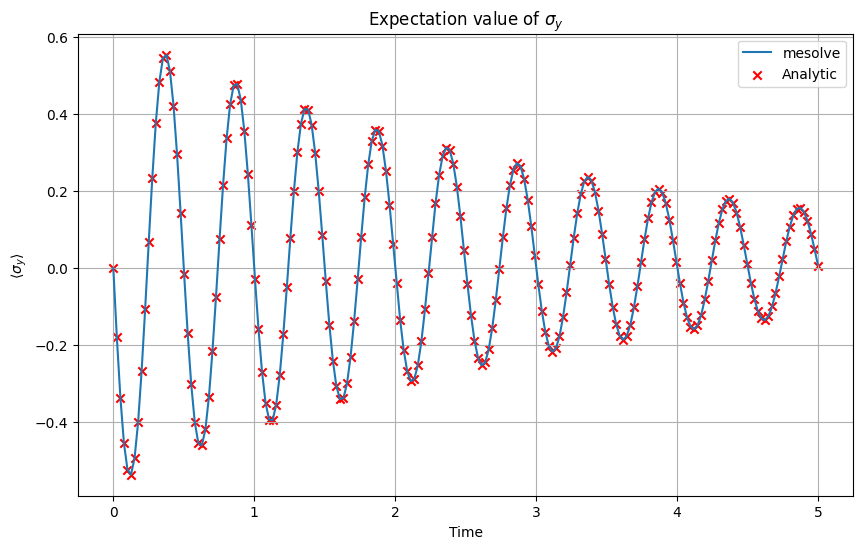

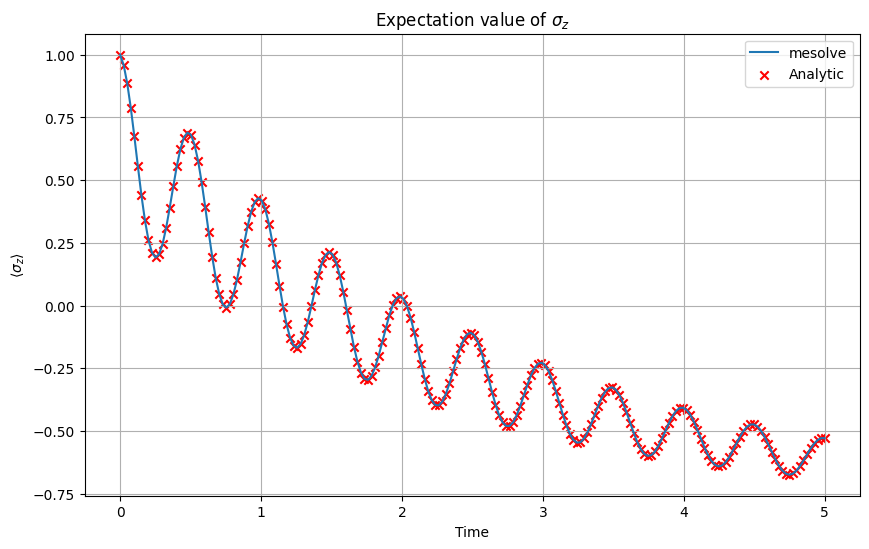

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from qutip import Bloch, about, basis, mesolve, sigmam, sigmax, sigmay, sigmaz

Delta = 2 * np.pi
hbar = 1.0
gamma = 0.5
theta =  0.2 * np.pi

t_span = (0, 5)
t_eval = np.linspace(*t_span, 200)


def drho_dt(t, y):
    rho11, rho22, rho12_real, rho12_imag, rho21_real, rho21_imag = y
    rho12 = rho12_real + 1j * rho12_imag
    rho21 = rho21_real + 1j * rho21_imag

    drho11_dt = -1j * (Delta /  hbar) * np.sin(theta) * (rho21 - rho12) -  gamma* rho11 
    drho22_dt = 1j * (Delta / hbar) * np.sin(theta)   * (rho21 - rho12) + gamma* rho11 
    drho12_dt = -1j * (Delta / hbar) * np.sin(theta)  * (rho22 - rho11) + (-2 * 1j * (Delta / hbar )* np.cos(theta) - gamma/2 ) * rho12
    drho21_dt = 1j * (Delta / hbar) * np.sin(theta)  * (rho22 - rho11) + (2 * 1j * (Delta / hbar )* np.cos(theta) - gamma/2 ) * rho21

    return [
        drho11_dt.real,
        drho22_dt.real,
        drho12_dt.real,
        drho12_dt.imag,
        drho21_dt.real,
        drho21_dt.imag
    ]


#----Analytic solution----
rho11_0 = 1.0
rho22_0 = 0.0
rho12_0 = 0.0 + 0.0j
rho21_0 = 0.0 + 0.0j

y0 = [rho11_0, rho22_0, rho12_0.real, rho12_0.imag, rho21_0.real, rho21_0.imag]

sol = solve_ivp(drho_dt, t_span, y0, t_eval=t_eval)

analytic_density_matrix_solution = solve_ivp(drho_dt, t_span, y0, t_eval=t_eval)

rho11 = analytic_density_matrix_solution.y[0]
rho22 = analytic_density_matrix_solution.y[1]
rho12 = analytic_density_matrix_solution.y[2] + 1j * analytic_density_matrix_solution.y[3]
rho21 = analytic_density_matrix_solution.y[4] + 1j * analytic_density_matrix_solution.y[5]

sigma_x_analytic = rho12 + rho21
sigma_y_analytic = 1j * (rho12 - rho21)
sigma_z_analytic = rho11 - rho22

#----QuTip solution----
psi0 = basis(2, 0)
H = Delta * (np.cos(theta) * sigmaz() + np.sin(theta) * sigmax())
c_ops = [np.sqrt(gamma) * sigmam()]

result = mesolve(H, psi0, t_eval, c_ops, [sigmax(), sigmay(), sigmaz()])
exp_sx_circ, exp_sy_circ, exp_sz_circ = result.expect

plt.figure(figsize=(10, 6))
plt.plot(t_eval, exp_sx_circ, label="mesolve")
plt.scatter(analytic_density_matrix_solution.t, sigma_x_analytic, label="Analytic",  c="r", marker="x" )
plt.xlabel('Time')
plt.ylabel(r"$\langle \sigma_x \rangle$")
plt.title(r"Expectation value of $\sigma_x$")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_eval, exp_sy_circ, label="mesolve")
plt.scatter(analytic_density_matrix_solution.t, sigma_y_analytic, label="Analytic",  c="r", marker="x" )
plt.xlabel('Time')
plt.ylabel(r"$\langle \sigma_y \rangle$")
plt.title(r"Expectation value of $\sigma_y$")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t_eval, exp_sz_circ, label="mesolve")
plt.scatter(analytic_density_matrix_solution.t, sigma_z_analytic, label="Analytic",  c="r", marker="x" )
plt.xlabel('Time')
plt.ylabel(r"$\langle \sigma_z \rangle$")
plt.title(r"Expectation value of $\sigma_z$")
plt.legend()
plt.grid(True)
plt.show()